In [1]:
import os
import datetime
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sn
from LandUseDataset import LandUseDataset, Mode
from Models import LandUseModelResnet50
from Models import LandUseModelResnet50NoFeatures, LandUseModelResnet152NoFeatures, LandUseModelVisionTransformerB16NoFeatures, LandUseModelDensenet161NoFeatures

torch.manual_seed(42)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
IMAGE_SIZE = 256 #FIXED
BATCH_SIZE = 128 #FIXED
LEARNING_RATE = 0.001 # 0.01, 0.001, 0.0001
EPOCH = 100 #FIXED
PATIENCE = 5 #FIXED
FACTOR = 0.1 #FIXED
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

transform = {
    "train":  transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomCrop(size=(224, 224)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "validation": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [3]:
train_dataset = LandUseDataset(Mode.TRAIN, transform=transform["train"], image_size=IMAGE_SIZE)
val_dataset = LandUseDataset(Mode.VALIDATION, transform=transform["validation"], image_size=IMAGE_SIZE)
test_dataset = LandUseDataset(Mode.TEST, transform=transform["validation"], image_size=IMAGE_SIZE)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=os.cpu_count())

In [5]:
model = LandUseModelVisionTransformerB16NoFeatures(len(train_dataset.classes), DEVICE).to(DEVICE)

loss_fn = nn.NLLLoss()
optimizer = optim.RAdam(model.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, factor=FACTOR)

print(model)

LandUseModelVisionTransformerB16NoFeatures(
  (base_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1):

In [6]:
print(f"Model: {model.name}")
print(f"CPU Count: {os.cpu_count()}")
print(f"Training on {DEVICE}")
print(f"Learing rate: {LEARNING_RATE}")
print(f"Image size: {IMAGE_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"Num classes: {len(train_dataset.classes)}")

Model: visiontransformerb16_nofeatures
CPU Count: 16
Training on cuda
Learing rate: 0.001
Image size: 256
Batch size: 128
Train: 43353, Validation: 5781, Test: 8676
Num classes: 33


In [7]:
if not os.path.exists(os.path.join("./Checkpoints", model.name)):
    os.makedirs(os.path.join("./Checkpoints", model.name))
    

ts = str(datetime.datetime.now()).split(".")[0].replace(":", "_")

folder_path = os.path.join("./Checkpoints", model.name, ts)
log_file = os.path.join("./Checkpoints", model.name, ts, "log.txt")

os.makedirs(folder_path)

with open(log_file, "w") as file:
    file.write(f"Training on {DEVICE}\n")
    file.write(f"Learing rate: {LEARNING_RATE}\n")
    file.write(f"Image size: {IMAGE_SIZE}\n")
    file.write(f"Batch size: {BATCH_SIZE}\n")
    file.write(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}\n")
    file.write(f"Base Model: {model.name}\n")
    file.write(f"Loss function: {str(loss_fn)}\n")
    file.write(f"Optimizer: {str(optimizer)}\n")
    file.write(f"Schedular: {str(scheduler)}\n")

In [8]:
with open(log_file, "a") as file:
    file.write("\nTRAINING Last Fully Connected Layer\n")

In [9]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
lrs = []

VAL_LOSS_PRECISION = 0.00001

BEST_MODEL_EPOCH = 0
VAL_LOSS_MIN = 10e10

In [10]:
for e in range(EPOCH):
    print(f"[{e+1}/{EPOCH}]")
    with open(log_file, "a") as file:
        file.write(f"[{e+1}/{EPOCH}]\n")
        
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f"    LEARNING RATE: {current_lr}")
    lrs.append(current_lr)
    
    with open(log_file, "a") as file:
        file.write(f"    LEARNING RATE: {current_lr}\n")
    
    model.train()
    running_loss = 0
    running_correct = 0
    for X, y in train_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        optimizer.zero_grad()
        
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        
        running_correct += (pred.argmax(dim=1) == y).float().sum().item()
        running_loss += loss.item()
    
    train_loss.append(running_loss / len(train_dataset))
    train_acc.append(100 * running_correct / len(train_dataset))
    
    print(f"    TRAIN: Loss: {running_loss / len(train_dataset):.7f}, Acc: {100 * running_correct / len(train_dataset):.5f}%")
    with open(log_file, "a") as file:
        file.write(f"    TRAIN: Loss:{running_loss / len(train_dataset)}, Acc:{100 * running_correct / len(train_dataset)}%\n")
        
    model.eval()
    running_loss = 0
    running_correct = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            loss = loss_fn(pred, y)
            
            running_correct += (pred.argmax(dim=1) == y).float().sum().item()
            running_loss += loss.item()
    
    scheduler.step(running_loss / len(val_dataset))
    val_loss.append(running_loss / len(val_dataset))
    val_acc.append(100 * running_correct / len(val_dataset))
    
    print(f"    VALIDATION: Loss: {running_loss / len(val_dataset):.7f}, Acc: {100 * running_correct / len(val_dataset):.5f}%")
    with open(log_file, "a") as file:
        file.write(f"    VALIDATION: Loss:{running_loss / len(val_dataset)}, Acc:{100 * running_correct / len(val_dataset)}%\n")
        
    torch.save({
        'epoch': e,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss_fn_state_dict': loss_fn.state_dict()
    }, os.path.join(folder_path, f"model_{model.name}_last_{e+1}.pt"))
    
    if running_loss / len(val_dataset) < VAL_LOSS_MIN:
        VAL_LOSS_MIN = running_loss / len(val_dataset)
        BEST_MODEL_EPOCH = e+1
        
    if len(val_loss) > 10:
        last_10 = val_loss[-10:]
        if abs(max(last_10) - min(last_10)) < VAL_LOSS_PRECISION:
            print("Early stop")
            break

[1/100]
    LEARNING RATE: 0.001
    TRAIN: Loss: 0.0068713, Acc: 76.27846%
    VALIDATION: Loss: 0.0026743, Acc: 89.15413%
[2/100]
    LEARNING RATE: 0.001
    TRAIN: Loss: 0.0021313, Acc: 91.24859%
    VALIDATION: Loss: 0.0018706, Acc: 92.50995%
[3/100]
    LEARNING RATE: 0.001
    TRAIN: Loss: 0.0017010, Acc: 92.86555%
    VALIDATION: Loss: 0.0016370, Acc: 93.56513%
[4/100]
    LEARNING RATE: 0.001
    TRAIN: Loss: 0.0014433, Acc: 93.99350%
    VALIDATION: Loss: 0.0017070, Acc: 93.20187%
[5/100]
    LEARNING RATE: 0.001
    TRAIN: Loss: 0.0012275, Acc: 94.80774%
    VALIDATION: Loss: 0.0014837, Acc: 94.27435%
[6/100]
    LEARNING RATE: 0.001
    TRAIN: Loss: 0.0011294, Acc: 95.12375%
    VALIDATION: Loss: 0.0013733, Acc: 94.56841%
[7/100]
    LEARNING RATE: 0.001
    TRAIN: Loss: 0.0010223, Acc: 95.60353%
    VALIDATION: Loss: 0.0014778, Acc: 94.48192%
[8/100]
    LEARNING RATE: 0.001
    TRAIN: Loss: 0.0009560, Acc: 95.87572%
    VALIDATION: Loss: 0.0012918, Acc: 94.81059%
[9/100]


Best Model Epoch: 30
Best Validation Epoch: 40


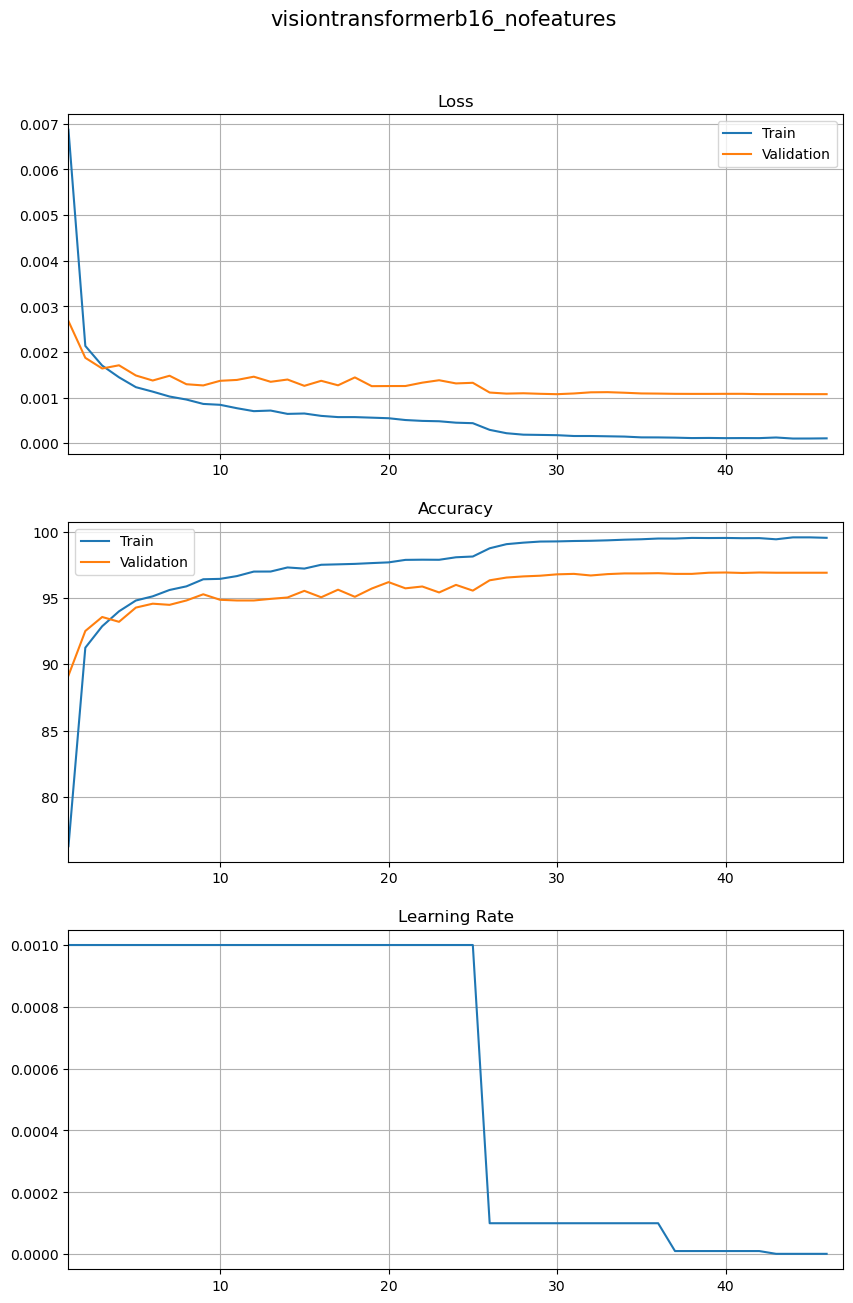

In [11]:
print(f"Best Model Epoch: {BEST_MODEL_EPOCH}")
print(f"Best Validation Epoch: {val_acc.index(max(val_acc))+1}")
fig, ax = plt.subplots(3, 1, figsize=(10,15))
fig.suptitle(f'{model.name}', fontsize=15, y=0.95)

ax[0].plot(
    list(range(1, 1+len(train_loss))), train_loss,
    list(range(1, 1+len(val_loss))), val_loss,
)
ax[0].set_title("Loss")
ax[0].legend(["Train", "Validation"])
ax[0].set_xlim([1, len(train_loss) + 1])
ax[0].grid()

ax[1].plot(
    list(range(1, 1+len(train_acc))), train_acc,
    list(range(1, 1+len(val_acc))), val_acc,
)
ax[1].set_title("Accuracy")
ax[1].legend(["Train", "Validation"])
ax[1].set_xlim([1, len(train_loss) + 1])
ax[1].grid()

ax[2].plot(list(range(1, 1+len(lrs))), lrs)
ax[2].set_title("Learning Rate")
ax[2].set_xlim([1, len(lrs) + 1])
ax[2].grid()


plt.show()

In [12]:
fig.savefig(os.path.join(folder_path, "fc_train_loss_acc.svg"))
with open(log_file, "a") as file:
    file.write(f"Best Epoch: {BEST_MODEL_EPOCH}\n")
    file.write(f"Best Validation Epoch: {val_acc.index(max(val_acc))+1}\n")

In [13]:
checkpoint = torch.load(os.path.join(folder_path, f"model_{model.name}_last_{BEST_MODEL_EPOCH}.pt"))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Results

In [14]:
y_target = []
y_pred = []

correct = 0

model.eval()
with torch.no_grad():        
    for X, y in tqdm(test_loader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X).argmax(dim=1)
        
        y_target.append(y.item())
        y_pred.append(pred.item())
        correct += (pred == y).float().sum().item()

100%|██████████| 8676/8676 [03:49<00:00, 37.76it/s]


In [15]:
labels = list(test_dataset.classes.keys())

y_pred_labels = [labels[i] for i in y_pred]
y_target_labels = [labels[i] for i in y_target]

data = precision_recall_fscore_support(y_target_labels, y_pred_labels, average=None, labels=labels)

In [16]:
print(f"Max Validation Set Accuracy: {max(val_acc):.3f}%")
print(f"Test Set Accuracy: {100 * correct / len(test_dataset):.3f}%")

table = []

for i, label in enumerate(labels):
    precision, recall, fscore, support = data[0][i], data[1][i], data[2][i], data[3][i]
    table.append([label, precision, recall, fscore, support])
    
df = pd.DataFrame(table, columns=["Class", "precision", "recall", "fscore", "support"])
df.to_csv(os.path.join(folder_path, "fc_train_results.csv"), sep=';')

with open(log_file, "a") as file:
    file.write(f"Test Set Accuracy: {100 * correct / len(test_dataset):.3f}%\n")
    file.write(f"Max Validation Set Accuracy: {max(val_acc):.3f}%\n")
    file.write(f"Avg Precision: {sum(data[0]) / 33}\n")
    file.write(f"Avg Recall: {sum(data[1]) / 33}\n")
    file.write(f"Avg F1 Score: {sum(data[2]) / 33}\n")

df

Max Validation Set Accuracy: 96.921%
Test Set Accuracy: 96.427%


,Class,precision,recall,fscore,support
0,Agricultural,0.965157,0.985765,0.975352,281
1,Airport,0.961832,0.947368,0.954545,399
2,Bareland,0.991453,0.995708,0.993576,233
3,Beach,0.996633,0.986667,0.991625,300
4,Bridge,0.981413,0.946237,0.963504,279
5,Buildings,0.893519,0.885321,0.889401,218
6,Cemetery,1.000000,0.975000,0.987342,120
7,Center,0.989744,0.989744,0.989744,195
8,Chaparral,0.995816,0.991667,0.993737,240
9,Coastal Mansion,0.966667,0.966667,0.966667,120


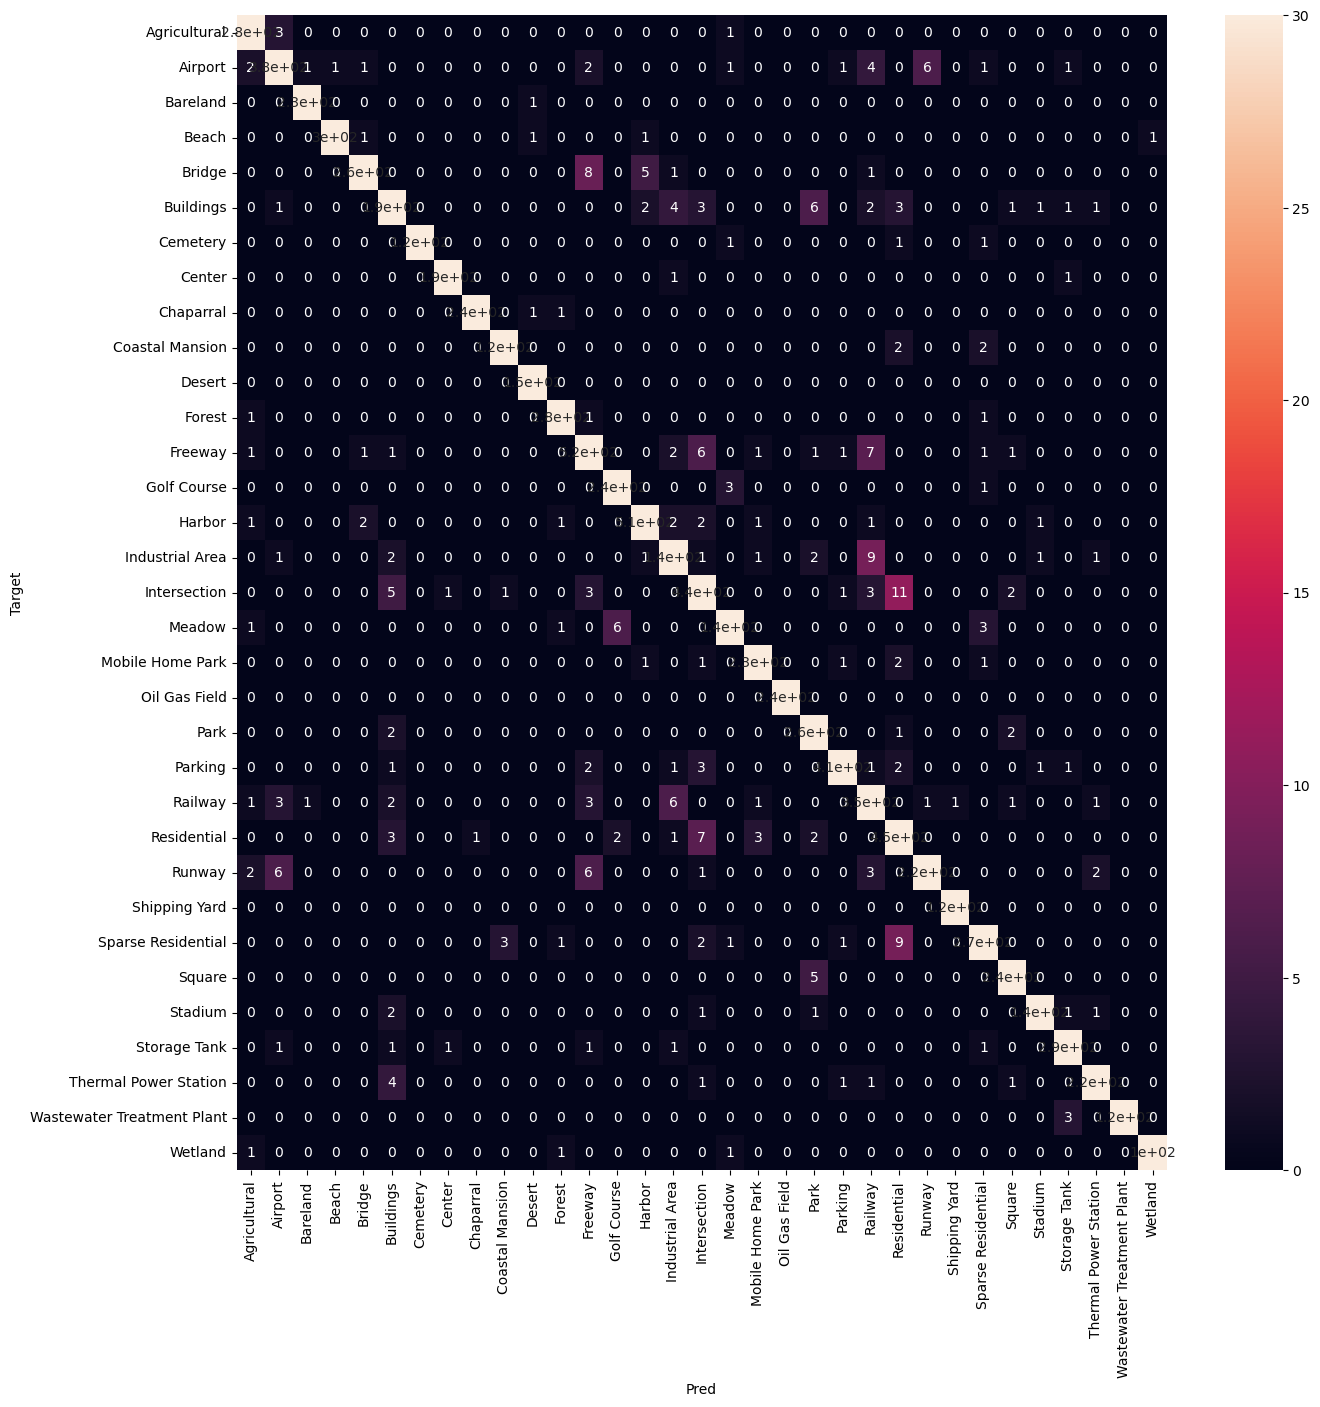

In [17]:
cf = confusion_matrix(y_true=y_target, y_pred=y_pred)
df_cm = pd.DataFrame(cf, index=[labels], columns=[labels])
plt.figure(figsize=(15,15))
ax = sn.heatmap(df_cm, annot=True, vmax=30)
ax.set(xlabel="Pred", ylabel="Target")
plt.savefig(os.path.join(folder_path, "fc_train_matrix.svg"))
plt.show()

### In range results

In [18]:
y_target = []
y_pred = []

correct = 0
incorrect = 0
incorrect_inrange = 0

model.eval()
with torch.no_grad():        
    for X, y in tqdm(test_loader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X)
        
        if pred.argmax(dim=1).item() != y.item():
            incorrect += 1
            
            pred_prob = 100 * pred[0][y].item()
            target_prob = 100 * pred[0][pred.argmax(dim=1).item()].item()
            
            if pred_prob - 2 < target_prob < pred_prob + 2:
                incorrect_inrange += 1
                y_target.append(y.item())
                y_pred.append(y.item())
            else:
                y_target.append(y.item())
                y_pred.append(pred.argmax(dim=1).item())

        else:
            correct += 1
            y_target.append(y.item())
            y_pred.append(pred.argmax(dim=1))
            
print(f"Test Set Accuracy: {100 * correct / len(test_dataset):.3f}%")
print(f"Test Set Accuracy 2% Range: {100 * (correct + incorrect_inrange) / len(test_dataset):.3f}%")
print(f"Incorrect in 2% Range: {100 * incorrect_inrange / incorrect}")

labels = list(test_dataset.classes.keys())

y_pred_labels = [labels[i] for i in y_pred]
y_target_labels = [labels[i] for i in y_target]

data = precision_recall_fscore_support(y_target_labels, y_pred_labels, average=None, labels=labels)

table = []

for i, label in enumerate(labels):
    precision, recall, fscore, support = data[0][i], data[1][i], data[2][i], data[3][i]
    table.append([label, precision, recall, fscore, support])
    
df = pd.DataFrame(table, columns=["Class", "precision", "recall", "fscore", "support"])
df.to_csv(os.path.join(folder_path, "fc_train_results_inrange.csv"), sep=';')

with open(log_file, "a") as file:
    file.write(f"Test Set Accuracy in range: {100 * (correct + incorrect_inrange) / len(test_dataset):.3f}%\n")
    file.write(f"Incorrect in 2% Range: {100 * incorrect_inrange / incorrect}\n")
    file.write(f"Avg Precision in range: {sum(data[0]) / 33}\n")
    file.write(f"Avg Recall in range: {sum(data[1]) / 33}\n")
    file.write(f"Avg F1 Score in range: {sum(data[2]) / 33}\n")

100%|██████████| 8676/8676 [03:51<00:00, 37.53it/s]


Test Set Accuracy: 96.427%
Test Set Accuracy 2% Range: 96.450%
Incorrect in 2% Range: 0.6451612903225806


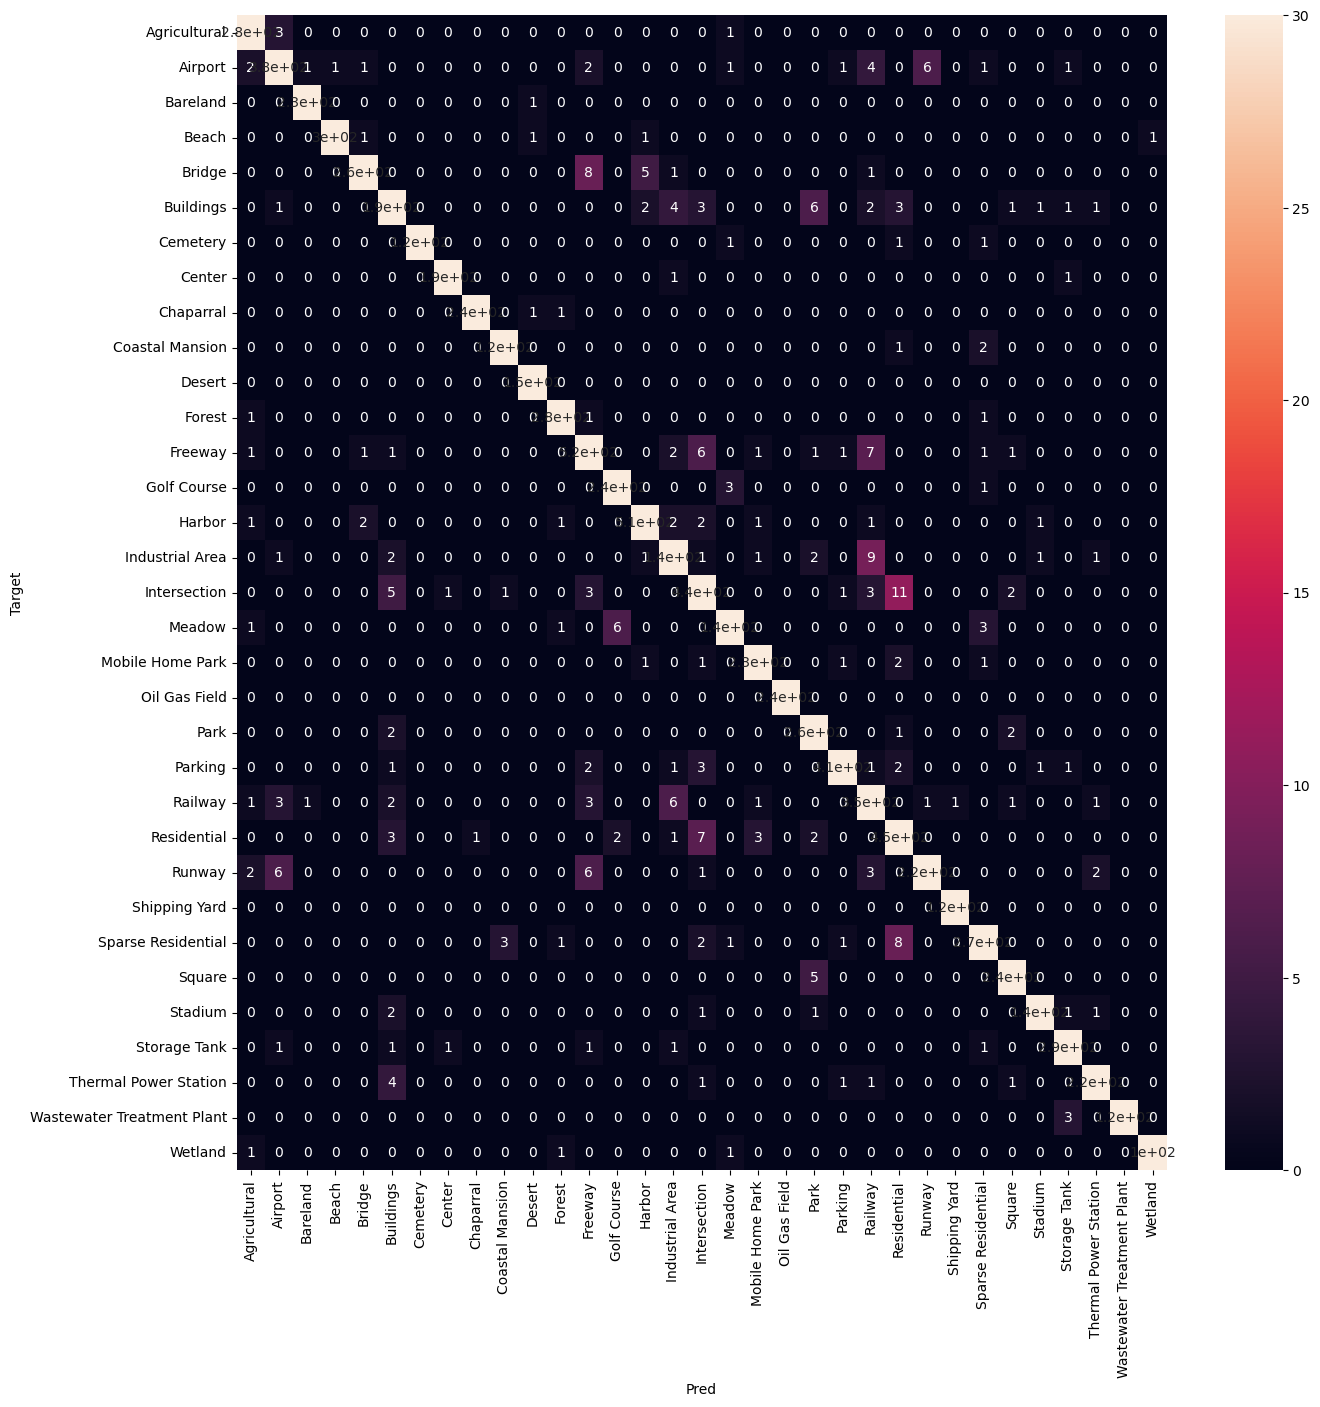

In [19]:
cf = confusion_matrix(y_true=torch.tensor(y_target, device="cpu"), y_pred=torch.tensor(y_pred, device="cpu"))
df_cm = pd.DataFrame(cf, index=[labels], columns=[labels])
plt.figure(figsize=(15,15))
ax = sn.heatmap(df_cm, annot=True, vmax=30)
ax.set(xlabel="Pred", ylabel="Target")
plt.savefig(os.path.join(folder_path, "fc_train_matrix_inrange.svg"))
plt.show()